Enviroment:

Python=3.10 \
keras-cv==0.5.1 \
keras-core \
Tensorflow 

Conjunto de datos para la deteccion de los colores de los semaforos, cuenta con 4564 imágenes y 4 clases

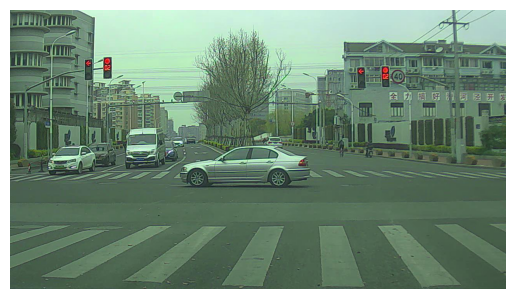

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ruta de la imagen
ruta_imagen = "Img/000000.jpg"

# Cargar la imagen
imagen = mpimg.imread(ruta_imagen)

# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')  # Desactivar ejes
plt.show()

Librerias

In [12]:
#!pip install keras-cv==0.5.1
#!pip install keras-core

#LIBRERIAS
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv
import requests
import zipfile

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization

Descarga del conjunto de datos

In [13]:
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size,
            unit='iB',
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')

download_file(
    'https://www.dropbox.com/scl/fi/suext2oyjxa0v4p78bj3o/S2TLD_720x1280.zip?rlkey=iequuynn54uib0uhsc7eqfci4&dl=1',
    'S2TLD_720x1280.zip')

File already present


In [14]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('S2TLD_720x1280.zip')

Extracted all


Hiperparametros

In [15]:
#HIPERPARAMETROS
SPLIT_RATIO = 0.2           #El 20% de los datos se reserva para validación
BATCH_SIZE = 8              #Tamaño de lotes
LEARNING_RATE = 0.001
EPOCH = 2
GLOBAL_CLIPNORM = 10.0      #Normalizacion global

Listas de rutas imagenes y anotaciones

In [16]:
#CLases
class_ids = ["red","yellow","green","off",]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "S2TLD_720x1280/images/"
path_annot = "S2TLD_720x1280/annotations/"

# Lista de path anotaciones y sortea
xml_files = sorted([
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")])

# Lista de path imagenes y sortea
jpg_files = sorted([
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")])

Se convierten las listas de rutas de imágenes, cajas delimitadoras y clases en tensores de TensorFlow.

In [17]:
def parse_annotation(xml_file):
    #Se lee los archivos xml
    tree = ET.parse(xml_file)
    root = tree.getroot()
    #Se encuentra el elemento "filename" en el XML para obtener el nombre de la imagen 
    # y luego se forma la ruta completa de la imagen concatenando el nombre de la imagen 
    # con la ruta al directorio de imágenes
    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)
    boxes = []      #Caja delimitadora
    classes = []    #Clases
    for obj in root.iter("object"):
        #Se encuentra el nombre de la clase del objeto y se agrega a la lista de clases.
        cls = obj.find("name").text
        classes.append(cls)
        #Se obtienen las coordenadas de la caja delimitadora 
        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
    #Se mapean las clases a identificadores
    class_ids = [list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes]
    return image_path, boxes, class_ids

image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/4564 [00:00<?, ?it/s]

Se utilizan las funciones 'tf.ragged.constant' para convertir las listas de cajas delimitadoras (bbox), clases (classes) y ruta de las imagenes (image_path) a tensores de tipo tf.RaggedTensor.

In [20]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

Se determina el número de muestras de validación y se divide el conjunto de datos en conjuntos de entrenamiento y validación.

In [21]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [22]:
#Funcion para cargar de imagenes
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image
#Funcion para cargar de imagenes para conjunto de entrenamiento y 
def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {"classes": tf.cast(classes, dtype=tf.float32),"boxes": bbox,}
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

Modelo para realizar aumentación de datos

- keras_cv.layers.RandomFlip = Esta capa voltea horizontalmente de la imagen y ajusta las coordenadas de las cajas delimitadoras en consecuencia.
- keras_cv.layers.JitteredResize = Esta capa redimensiona la imagen de manera aleatoria y aplica jitter (variación aleatoria) a las coordenadas de las cajas delimitadoras. En este caso, se especifica un tamaño objetivo de (640, 640) y un factor de escala de (1.0, 1.0).

In [ ]:
#Se define un secuencial de capas de Keras para realizar aumentación de datos, 
# que incluye volteo aleatorio y redimensionamiento.
augmenter = keras.Sequential(
    layers=[keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
            keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(1.0, 1.0),
            bounding_box_format="xyxy",),])

#Se aplican una serie de transformaciones y operaciones al conjunto de datos de entrenamiento
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
#Otro modelo para redimensionamiento
resizing = keras_cv.layers.JitteredResize(target_size=(640, 640),
                                          scale_factor=(1.0, 1.0),
                                          bounding_box_format="xyxy",)

#Se aplican una serie de transformaciones y operaciones al conjunto de datos de validacion
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

Visualizacion de la aumentacion de datos

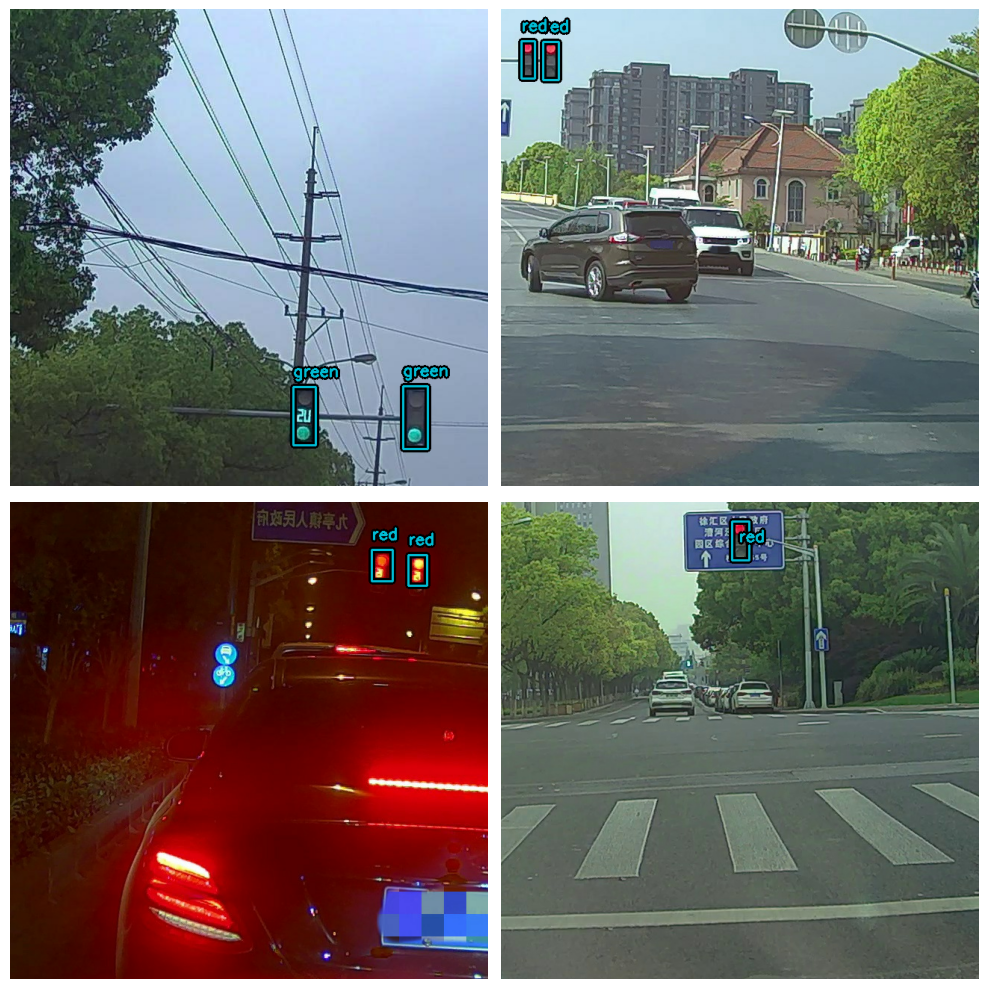

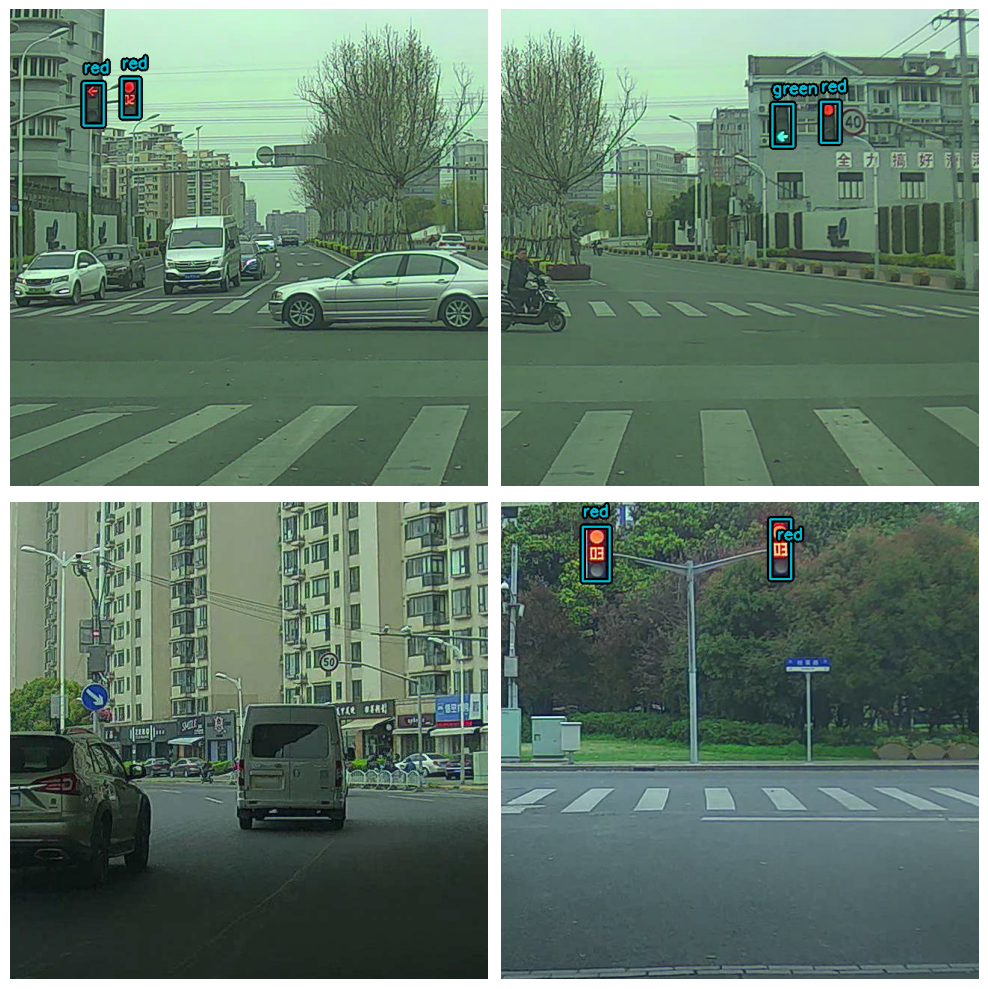

In [24]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,)


visualize_dataset(train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

visualize_dataset(val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

In [ ]:
#Funcion que agrupa la imagen a la caja delimitadora 
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]
#Trasformaciones
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
#Carga de modelo para deteccion

#### El modelo KerasCV YOLOv8

El modelo tiene 53 capas en total, Convolucionales: 46 capas, MaxPool: 1 capa, Upsampling: 2 capas, Concatenate: 1 capa, Flatten: 2 capas, Dense: 1 capa

In [26]:
#Carga de modelo y pesos para la deteccion
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_l_backbone_coco",load_weights=True)
yolo = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                      bounding_box_format="xyxy",
                                      backbone=backbone,
                                      fpn_depth=3,)
#Parametros del modelo
#num_classes = número de clases en el conjunto de datos
#bounding_box_format = coordenadas de las cajas delimitadoras
#backbone = modelo cargado anteriormente
#fpn_depth = profundidad de la Feature Pyramid Network (FPN) en el modelo.
yolo.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    1983174   ['input_2[0][0]']             
                             256),                        4                                       
                              'P4': (None, None, None,                                            
                             512),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                  

In [27]:
#Se define el optimizador 
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,global_clipnorm=GLOBAL_CLIPNORM,)
#Se compila 
yolo.compile(optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou")

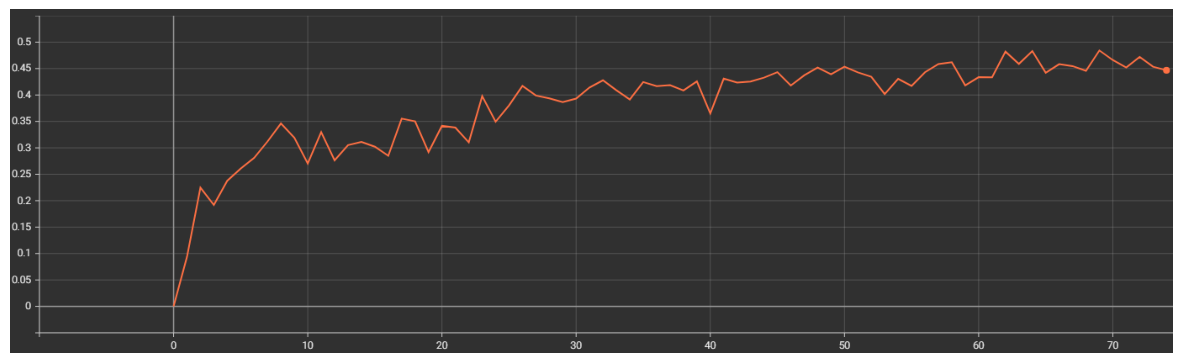

In [10]:
import PIL
import matplotlib.pyplot as plt

# Cargamos la imagen
image = PIL.Image.open("Img/kerascv-yolov8-map.png")

# Obtenemos el tamaño de la imagen
width, height = image.size

# Obtenemos los píxeles de la imagen
pixels = image.getdata()
plt.figure(figsize=(15, 10))
# Mostrar la imagen
plt.imshow(image)
plt.axis('off')  # Desactivar ejes
plt.show()

El modelo YOLOv8 alcanza el mejor mAP de más del 48%. Aquí es donde también se guardan los mejores pesos de los modelos.

#### Evaluacion de rendimiento del modelo

Se determina la precicion del modelo a tras ves de mPA (precisión media promedio)

In [28]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(bounding_box_format="xyxy",evaluate_freq=1e9,)
        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

#### Entrenamiento 

In [ ]:
history = yolo.fit(train_ds,
                   validation_data=val_ds,
                   epochs=EPOCH,
                   callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model_yolov8large.h5"),tensorboard_callback],)

Epoch 1/2
  1/456 [..............................] - ETA: 20:23:53 - loss: 12408.6270 - box_loss: 6.5995 - class_loss: 12402.0273

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    for i in range(10):
        images, y_true = next(iter(dataset.take(i+1)))
        y_pred = model.predict(images)
        y_pred = bounding_box.to_ragged(y_pred)
        visualization.plot_bounding_box_gallery(
            images,
            value_range=(0, 255),
            bounding_box_format=bounding_box_format,
            # y_true=y_true,
            y_pred=y_pred,
            scale=4,
            rows=2,
            cols=2,
            show=True,
            font_scale=0.7,
            class_mapping=class_mapping,)
visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

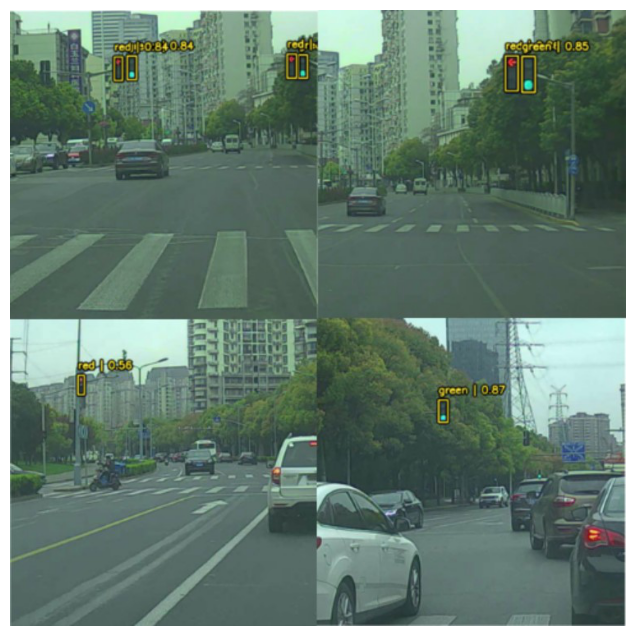

In [5]:
# Ruta de la imagen
ruta_imagen = "Img/2.jpg"

# Cargar la imagen
imagen = mpimg.imread(ruta_imagen)
plt.figure(figsize=(10, 8))
# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')  # Desactivar ejes
plt.show()

Se puede aplicar este modelo a videos con 
	
python infer_video.py --input inference_data/video.mov

In [6]:
from IPython.display import Video

# Ruta del archivo .mp4
ruta_video = 'Img/kerascv-yolov8-video-inference.mp4'

# Reproducir el video en el cuaderno
Video(ruta_video)